# Data exploration and feature extraction

In [1]:
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import missingno as msno
import seaborn as sns
import tensorflow as tf
import os as os

Load the images from the three sets (train, validation, and test). Since the images will be fed to a pretrained model for feature extraction, make sure to set the scale of the pixels and the image size as expected by the model (you can check the expected scale and size in the official documentation page)

## Loading images and print one image by folder
We use the librairie OS to manipulate folders and image files. We use the pretrained model mobile net to convert the images data into high level features which will be used by the various machine learning models. To feed the model, the input images are expected to have color values in the range [0,1], following the common image input conventions. In addition, the size of the input images is fixed to height x width = 224 x 224 pixels.


In this first code, we are creating a loop to load images, converts it into numpy array and add a label

In [2]:
notebook_directory = os.getcwd()

In [3]:
# Folder list
folder_list = ["bike", "car", "motorcycle", "other", "truck", "van"]

Looking at the various folders, we can see that images are well organized with a strong regularity among pictures names. 

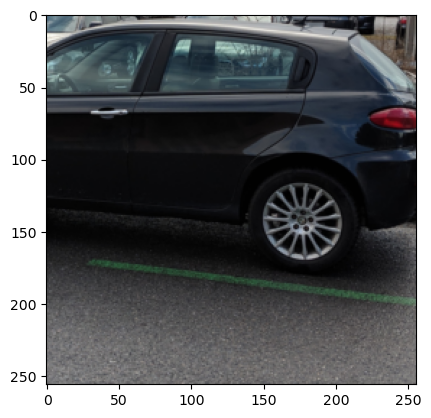

In [4]:
# Plotting 1 image
notebook_directory = os.getcwd()
train_path = os.path.join(notebook_directory, "test", "car", "car-0097.png" )
img = Image.open(train_path)
plt.imshow(img)
plt.show()

In [5]:
image_width, image_height = img.size
print(f"Image shape (width, height): ({image_width}, {image_height})")


Image shape (width, height): (256, 256)


*Comments:* the shape of each picture is 256 x 256 in RGB format and must be converted into 224 x 224 images.

## Plot a few images from each category (bike, car, motorcycle, other, truck, van).

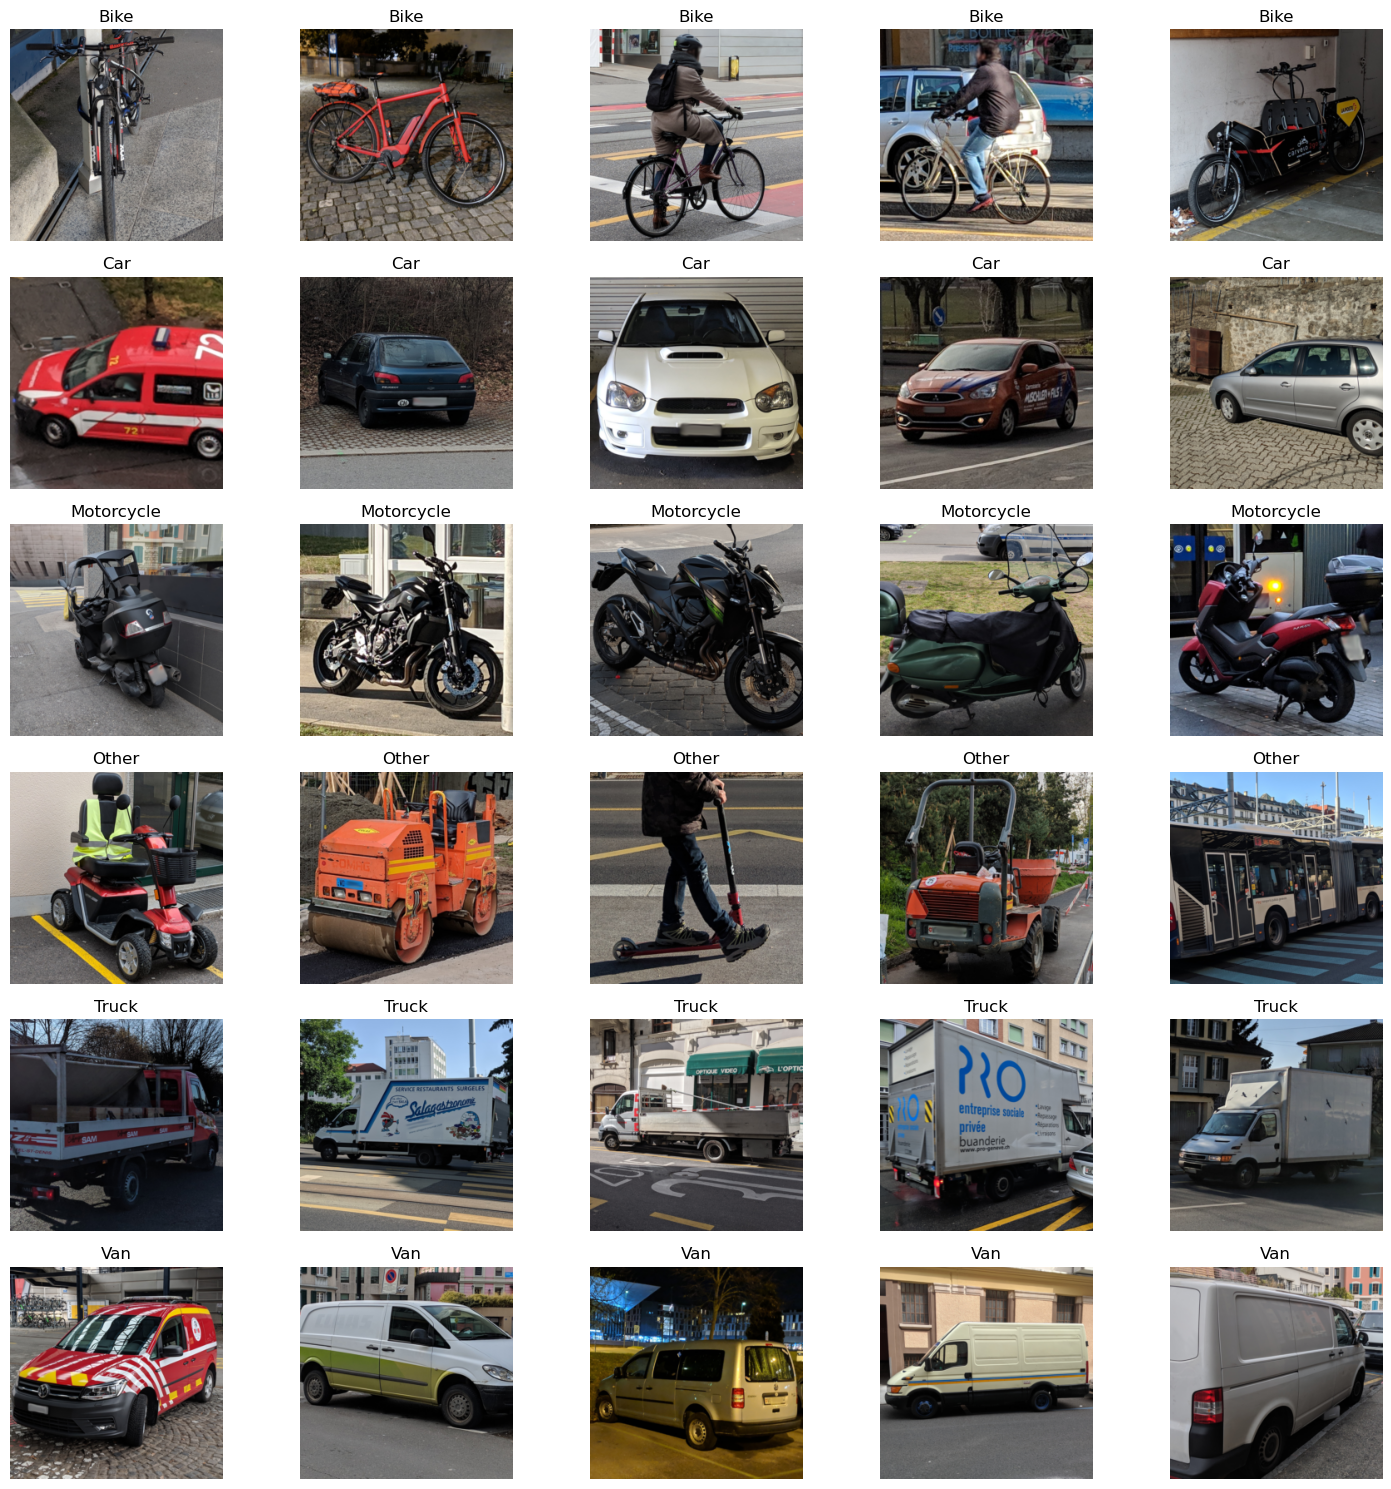

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Get the folder location
notebook_directory = os.getcwd()
train_path = os.path.join(notebook_directory, "train")

# Automatically get folder names (class labels)
folder_list = ["bike", "car", "motorcycle", "other", "truck", "van"]

# Create variables to store data
images = []
titles = []

# Number of images to display per category
num_images_cat = 5

# Create a loop to store the images and names into the variables
for name in folder_list:
    for i in range(num_images_cat):
        file_name = f"{name}-{i+1:04d}.png"  # Ensure your filenames follow this format
        path = os.path.join(train_path, name, file_name)
        try:
            img = Image.open(path)
            images.append(img)
            titles.append(name.capitalize())
        except FileNotFoundError:
            print(f"File not found: {path}")

# Plot the images
fig, axes = plt.subplots(len(folder_list), num_images_cat, figsize=(15, 15))

for i, ax_row in enumerate(axes):  # Each row corresponds to a category
    for j, ax in enumerate(ax_row):  # Each column corresponds to an image within the category
        idx = i * num_images_cat + j
        if idx < len(images):  # Ensure there's an image to display
            ax.imshow(images[idx])
            ax.set_title(titles[idx])
            ax.axis("off")

plt.tight_layout()
plt.show()

# Code made with the assistance of Chatgpt (openAI)

*Comments:* Looking at the various folders and plotted images, we can see that the images are well-organized, with strong regularity in picture naming conventions. However, the images of vehicles are taken from various angles (front, back, side) and under different lighting conditions (daylight, night). This variation may introduce additional challenges for the model to classify images properly.
Models might struggle to classify vans and other vehicles correctly due to the wide diversity of vans based on their functions (e.g., ambulances, leisure vehicles, plumber vans). Additionally, the "other" category includes a broad range of vehicles, from scooters and buses to toys and road construction machines, further complicating classification.

In [7]:
# Paths for train, validation, and test folders
train_path = os.path.join(notebook_directory, "train")
val_path = os.path.join(notebook_directory, "valid")
test_path = os.path.join(notebook_directory, "test")

## Use an appropriate visualization to show the proportions of each category in the three sets (train, validation, and test).

#Comments:* We are estimating the proportion of each category based on the pictures label. First, we store labels into a variable before counting the number of instance and plotting it with a vertical bar chart.

In [12]:
# Function to create 3 labels variable to store category names.
def load_labels(folder_path):
    labels = []
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            img_label = file_name.split('-')[0]
            # append the list
            labels.append(img_label)
    return labels

In [13]:
train_labels = load_labels(train_path)
test_labels = load_labels(test_path)
val_labels = load_labels(val_path)

In [14]:
# We count the number of values in each category
train_counts = pd.Series(train_labels).value_counts()
test_counts = pd.Series(test_labels).value_counts()
val_counts = pd.Series(val_labels).value_counts()


In [15]:
# Showing the number of categories and instance in the train set
train_counts

bike          66
car           64
motorcycle    51
truck         42
other         32
van           25
dtype: int64

In [16]:
# Create a dataframe with the 3 sets and their values
proportion = pd.DataFrame({"train":train_counts, 
              "test":test_counts, 
              "validation": val_counts})
proportion

,train,test,validation
bike,66,12,33
car,64,11,32
motorcycle,51,9,25
other,32,8,16
truck,42,7,21
van,25,5,12


In [17]:
# Convert counts to percentages
proportion_percent = proportion.div(proportion.sum(axis=0), axis=1) * 100

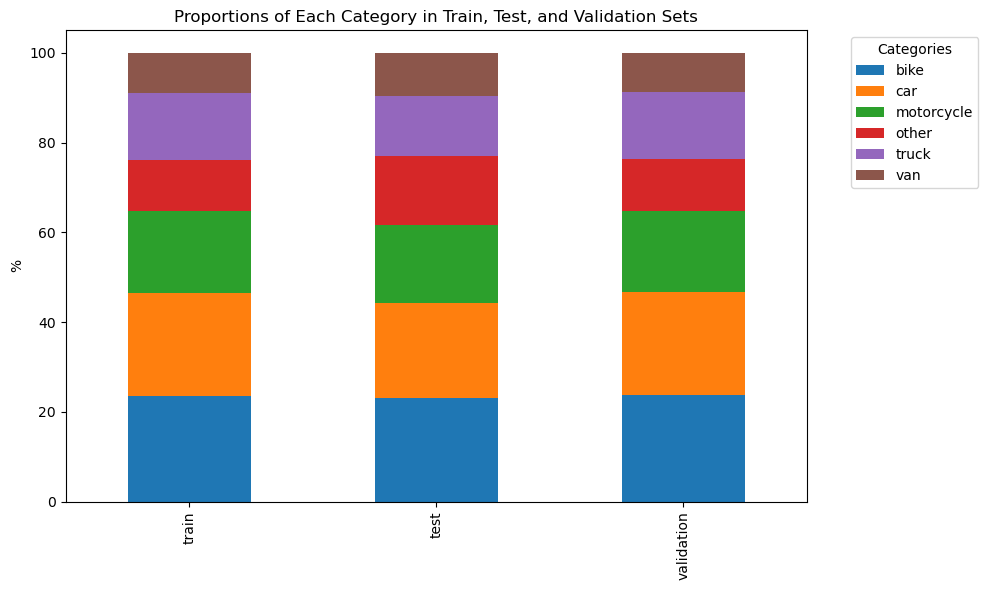

In [18]:
# Plot a stacked bar chart to show the proportion of each category in the 3 sets
proportion_percent.T.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title("Proportions of Each Category in Train, Test, and Validation Sets")
plt.ylabel("%")
plt.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

# Show the chart
plt.show()

*Comments:* We can see that each category into the 3 sets is similar which is a good new for our models as it limits the biaises on unknown test sets data.

## Extract features

In [8]:
# Create the image feature extractor
model_url = "https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/100-224-feature-vector/2"

In [9]:
feature_extractor = hub.load(model_url)

In [10]:
# Function to all images into a variable resize images, rescale and convert into a numpy array 32 bytes
def load_images_convert(folder_path):
    hl_images = []
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            # Open image
            img = Image.open(file_path)
            # Resize images to fit with the pretrained model
            img_resized = img.resize((224, 224), resample=Image.BILINEAR)
            # Convert train_features to float32 and frame data between 0 and 1
            img_array = np.array(img_resized, dtype=np.float32)[np.newaxis, :, :, :] / 255
            # convert image in high level features with the pretrained model 
            features = feature_extractor(img_array)
            hl_images.append(features)
    return hl_images

In [11]:
# Convert the datasets formats
train_array = load_images_convert(train_path)
test_array = load_images_convert(test_path)
val_array = load_images_convert(val_path)

## For each of the 6 categories in the training dataset, answer the following questions:
- What are the top 5 features that have the highest mean value?
- Which categories share the same most active feature (i.e. have highest means)?

*Comments* For this exercice, we need to combine the list of image names with the numpy matrix of high level features.As "train array" is a 3D matrix, we reshape it to get a 2D matrix in 280x1280. Then, we will calculate the mean for each features in each group of image

In [19]:
# 1 Combine the list of names with high level features

In [20]:
train_array_np = np.array(train_array)
test_array_np = np.array(test_array)
val_array_np = np.array(val_array)
train_array_np.shape, test_array_np.shape, val_array_np.shape

((280, 1, 1280), (52, 1, 1280), (139, 1, 1280))

In [21]:
# convert labels into numpy format and reshape the list
train_labels_np = np.array(train_labels)
train_labels_np = train_labels_np.reshape(-1, 1)
test_labels_np = np.array(test_labels)
test_labels_np = test_labels_np.reshape(-1, 1)
val_labels_np = np.array(val_labels)
val_labels_np = val_labels_np.reshape(-1, 1)

In [22]:
# reshape the train array np into a 2D dimension matrix
train_array_np = train_array_np.reshape(280, 1280)
test_array_np = test_array_np.reshape(52, 1280)
val_array_np = val_array_np.reshape(139, 1280)

In [23]:
print(f"the train_array shape is {train_array_np.shape} and the type is {train_array_np.dtype}")
print(f"the train_label shape is {train_labels_np.shape} and the type is {train_labels_np.dtype}")

the train_array shape is (280, 1280) and the type is float32
the train_label shape is (280, 1) and the type is <U10


In [24]:
# We concatenate the date matrix and labels into a new variable 
labeled_matrix = np.concatenate((train_array_np, train_labels_np), axis=1)
print(f"the labeled matrix shape is {labeled_matrix.shape} and the type is {labeled_matrix.dtype}")

the labeled matrix shape is (280, 1281) and the type is <U32


*Comments:* There are 280 rows and 1280 features of data and one last column of lebels. 

In [25]:
# Calculation of the mean of each feature for each category of vehicule and select the 5 highest features

In [26]:
# Initialize a variable to store results

data = labeled_matrix[:, :-1].astype(float)  # Convert numeric columns to float
labels = labeled_matrix[:, -1]  # Extract labels as strings

results = []
# Loop through each category in folder_list
for category in folder_list:
    # Select data for the current category
    category_data = data[labels == category]
    # Calculate mean for each feature
    category_means = np.mean(category_data, axis=0)
    # select the 5 highest means
    top_5_indices = np.argsort(category_means)[-5:][::-1]
    top_5_means = category_means[top_5_indices]
    # Store the results in the list
    for feature, mean in zip(top_5_indices, top_5_means):
        results.append({"Category": category, "Feature": feature, "Mean": mean})
# Convert results to a DataFrame
df_results = pd.DataFrame(results)
df_results_sorted = df_results.sort_values(by=["Category", "Mean"], ascending=[False, False])


In [27]:
#df_results_sorted
df_results_sorted.sort_values(ascending=False, by="Category")

,Category,Feature,Mean
25,van,1022,2.074563
27,van,466,1.764156
28,van,165,1.708883
29,van,893,1.674993
26,van,1104,1.795218
22,truck,580,1.725204
24,truck,335,1.616397
23,truck,714,1.671769
21,truck,1022,1.946464
20,truck,165,2.417244


**Comments:** 

*Min/Max:*
- The Truck category has some of the highest mean values overall, with Feature 165 leading at 2.4127. showing that it might be the category with the most significant variations in this feature compared to others.This Feature 165 appears in:
Truck (highest mean: 2.41), Van (4th place with a mean: 1.7, Other (highest mean: 1.780518, Car (4th place with a mean: 1.705816)

- "Other" has the lowest maximum mean value among its top 5 features, suggesting that its key features are less impactful or spread more evenly. 

**Overlaps:**
- Categories like Bike and Motorcycle have no overlap with other categories in terms of their top features which suggests that these categories are more distinct in their feature importance.
- We can mention that Van and truck share the same feature 1022. indicating potential overlap in behaviors or attributes. However, Truck’s values are generally higher for this feature.
- In addition, truck, car and other share the same high feature 165. Indeed, these vehicules share some common aspects which have been detected by the pre trained model.

**Conclusion**
High-mean features like 165 and 1022 should be investigated further to understand what these features represent and how they contribute to categorization.


In [28]:
# Save the high levels features into a npz file and remove 1 dimension in the label
np.savez("train_data_np.npz", features=train_array_np, targets=train_labels_np.ravel())
np.savez("test_data_np.npz", features=test_array_np, targets= test_labels_np.ravel())
np.savez("val_data_np.npz", features=val_array, targets=val_labels_np.ravel())